In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image
from io import StringIO

from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

# Problem Set 7

This is the `python` version of *Exercise_7_class_tree.R*

## Exercise 1

Consider the following data generating process in which we have $n$ observations and two covariates $X_1 \sim N(0,4)$ and $X_2 \sim N(0,4)$. The model is generated by $y_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{1i}^2 + \beta_3x_{2i}+ \beta_4 x_{2i}^2 + \epsilon_i$ with $\epsilon \sim N(0,1)$ and $n=250$. $\beta_1=0.5$, $\beta_2=1.5$, $\beta_3=-1$, $\beta_4=0.5$.

In [2]:
def print_tree(estimator, features, class_names=None, filled=True):
    """
    Unlike in R, the plot function for tree-based methods in python has to be defined
    by programmer himself. This function is used for plotting decision trees.
    The orginal author is JWarmenhoven:
    https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%208.ipynb
    """
    dot_data = StringIO()
    export_graphviz(estimator,
                    out_file=dot_data,
                    feature_names=features, 
                    class_names=class_names,
                    filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    
    return graph

In [3]:
def data_gen(nobs, k):
    """
    Data generating function.
    """
    X1 = np.random.normal(0, 2, nobs)
    X2 = np.random.normal(0, 2, nobs)
    eps = np.random.standard_normal(nobs)

    if k == 1:
        X1_sq = X1 ** 2
        X2_sq = X2 ** 2

        xdict = {'X1': X1, 'X1_sq': X1_sq, 'X2': X2, 'X2_sq': X2_sq}
        X = pd.DataFrame(xdict)
        beta = np.array([0.5, 1.5, -1, 0.5])
        y = X @ beta + eps

    if k == 3:
        xdict = {'X1': X1, 'X2': X2}
        X = pd.DataFrame(xdict)
        beta = np.array([0.5, -1])
        y = X @ beta + eps

    if k == 2:
        xdict = {'X1': X1, 'X2': X2}
        X = pd.DataFrame(xdict)

        X['I1_X1'] = X.X1.map(lambda x: 1 if x < 1 else 0)
        X['I1_X2'] = X.X2.map(lambda x: 1 if x < 0.2 else 0)
        X['I2_X1'] = X.I1_X1.map(lambda x: (not x) * 1)
        X['I2_X2'] = X.I1_X2.map(lambda x: (not x) * 1)
        y = 5 * (X.I1_X1 * X.I1_X2) + 4 * (X.I1_X1 * X.I2_X2) + 3 * X.I2_X1 + eps

    # If k is not 1 or 2 or 3.
    assert (k == 1) | (k == 2) | (k == 3), 'Please choose the value of k from {1, 2, 3}.'
    
    return y, X

**a)** Generate the data according to the dgp described above and fit a regression tree.

In [4]:
# Parameters for non-linear model.
n = 250
k = 1

# Data generating.
y, X = data_gen(n, k)

In [5]:
# Decision tree fitting.
tree1 = DecisionTreeRegressor(max_leaf_nodes=11)
tree1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=11, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

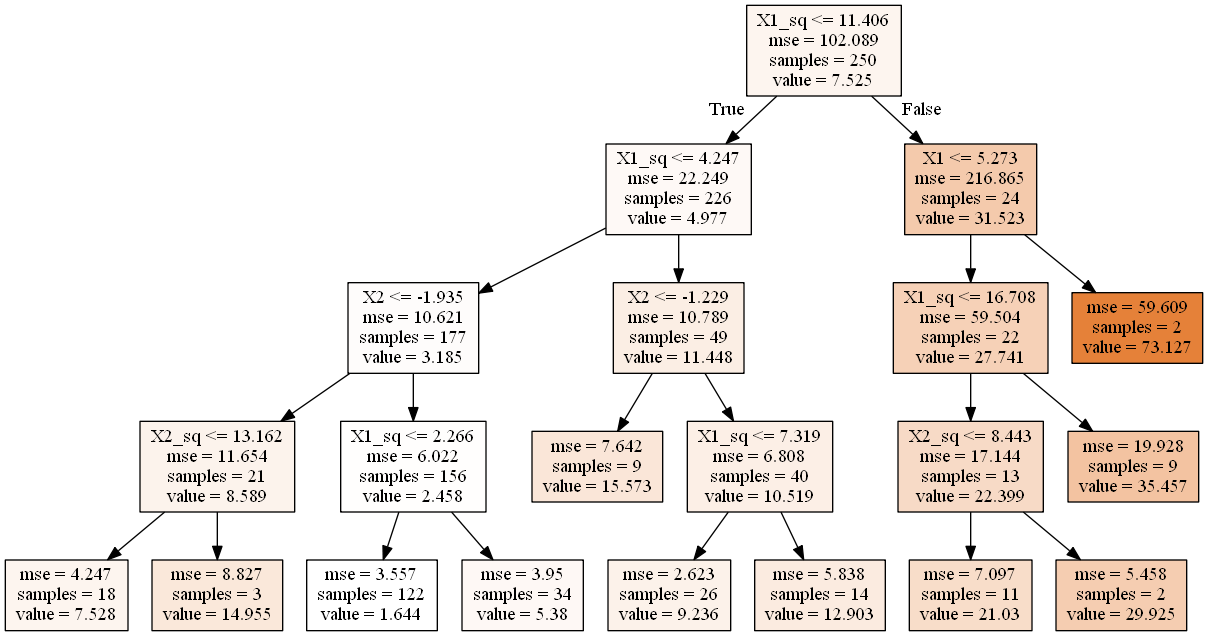

In [6]:
graph, = print_tree(tree1, features=X.columns)
Image(graph.create_png())

**b)** Use a newly generated test data set to calculate the mean squared error using a linear regression model
(ignoring the nonlinearities in $x$ in the true model, i.e. $\hat{\beta}$ has two elements) and the values resulting from
fitting the tree in a).

In [7]:
# OLS coefficient.
beta_hat_1 = np.linalg.solve(X.T @ X, X.T @ y)

# Generate test data.
y_test, X_test = data_gen(n, k)

# Calculate MSEs for both methods #

# OLS prediction.
y_hat_test = X_test @ beta_hat_1

# Tree method prediction.
y_hat_tree = tree1.predict(X_test)

# MSE.
mse_test = mean_squared_error(y_test, y_hat_test)
mse_tree = mean_squared_error(y_test, y_hat_tree)
print('OLS mse: {}\nTree mse: {}'.format(mse_test, mse_tree))

OLS mse: 0.9939178669283574
Tree mse: 13.870489373027905


In [8]:
# Function for generating new mse ratios.
def sim_fun(nobs, k, fit_coef, tree):
    """
    """
    y_test, X_test = data_gen(nobs, k)
    
    if k == 2:
        X_test = X_test[['X1', 'X2']]
        
    y_hat_test = X_test @ fit_coef
    y_hat_tree = tree.predict(X_test)
    
    mse_test = mean_squared_error(y_test, y_hat_test)
    mse_tree = mean_squared_error(y_test, y_hat_tree)
    
    ratio = mse_test / mse_tree
    
    return ratio

Text(0.5, 1.0, 'Model 1: Non-linear True model')

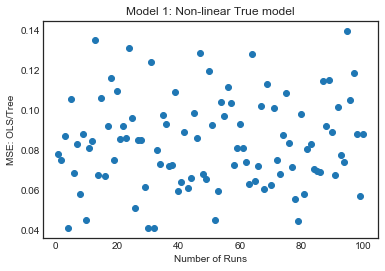

In [9]:
# Small MC experiments.
ratios = []
for _ in np.arange(100):
    ratios.append(sim_fun(n, k, beta_hat_1, tree1))

# Plot.
ax = plt.gca()
ax.plot(np.arange(100) + 1, ratios, 'o')
ax.set_xlabel('Number of Runs')
ax.set_ylabel('MSE: OLS/Tree')
ax.set_title('Model 1: Non-linear True model')

## Exercise 2

The goal here is to think about *how* a regression tree makes its predictions and consequently when a regression
tree might yield a better result than other methods.

* Propose a dgp that will be well suited for analysis using regression trees and evaluate relevant properties
  in a small simulation study.

* Propose a dgp that will be well suited for analysis using the linear regression model (i.e. where the linear
    regression model is more likely to “beat" the regression tree method) and evaluate.

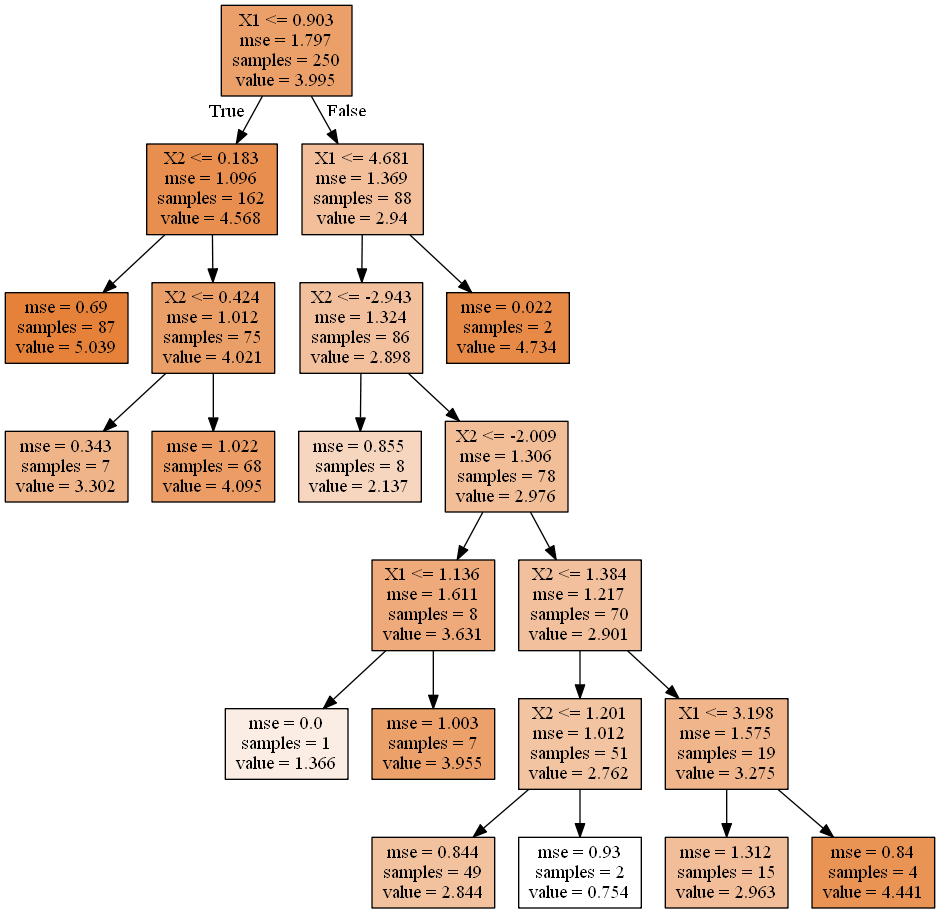

In [10]:
# Implement Model 2 #
k = 2

# Data generating.
y, X = data_gen(n, k)
X = X[['X1', 'X2']]

# Decision tree fitting.
tree2 = DecisionTreeRegressor(max_leaf_nodes=11)
tree2.fit(X, y)

graph, = print_tree(tree2, features=X.columns)
Image(graph.create_png())

In [11]:
# OLS coefficient.
beta_hat_2 = np.linalg.solve(X.T @ X, X.T @ y)

# Generate test data.
y_test, X_test = data_gen(n, k)
X_test = X_test[['X1', 'X2']]

# Calculate MSEs for both methods #

# OLS prediction.
y_hat_test = X_test @ beta_hat_2

# Tree method prediction.
y_hat_tree = tree2.predict(X_test)

# MSE.
mse_test = mean_squared_error(y_test, y_hat_test)
mse_tree = mean_squared_error(y_test, y_hat_tree)
print('OLS mse: {}\nTree mse: {}'.format(mse_test, mse_tree))

OLS mse: 18.166018236394592
Tree mse: 1.3472834719066396


Text(0.5, 1.0, 'Model 2: Areas')

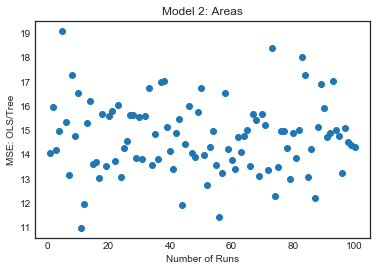

In [12]:
# Small MC experiments.
ratios = []
for _ in np.arange(100):
    ratios.append(sim_fun(n, k, beta_hat_2, tree2))

# Plot.
ax = plt.gca()
ax.plot(np.arange(100) + 1, ratios, 'o')
ax.set_xlabel('Number of Runs')
ax.set_ylabel('MSE: OLS/Tree')
ax.set_title('Model 2: Areas')

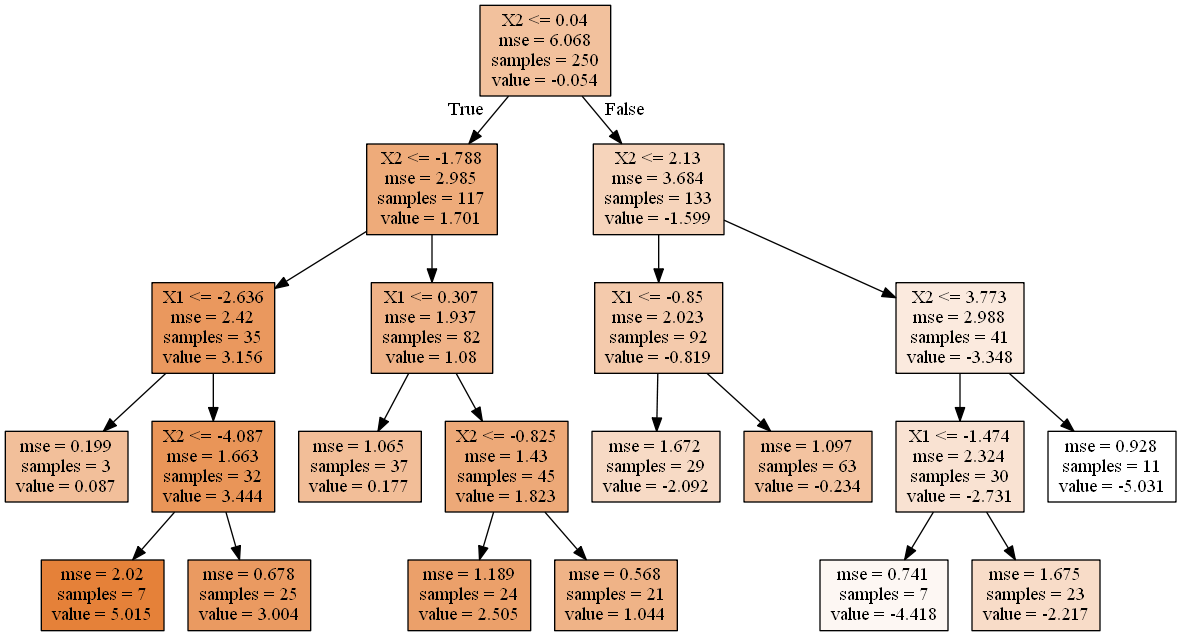

In [13]:
# Implement model 3 #
k = 3

# Data generating.
y, X = data_gen(n, k)
X = X[['X1', 'X2']]

# Decision tree fitting.
tree3 = DecisionTreeRegressor(max_leaf_nodes=11)
tree3.fit(X, y)

graph, = print_tree(tree3, features=X.columns)
Image(graph.create_png())

In [14]:
# OLS coefficient.
beta_hat_3 = np.linalg.solve(X.T @ X, X.T @ y)

# Generate test data.
y_test, X_test = data_gen(n, k)

# Calculate MSEs for both methods #

# OLS prediction.
y_hat_test = X_test @ beta_hat_3

# Tree method prediction.
y_hat_tree = tree3.predict(X_test)

# MSE.
mse_test = mean_squared_error(y_test, y_hat_test)
mse_tree = mean_squared_error(y_test, y_hat_tree)
print('OLS mse: {}\nTree mse: {}'.format(mse_test, mse_tree))

OLS mse: 0.9275450821211156
Tree mse: 1.9084332311046772


Text(0.5, 1.0, 'Model 3: Linear Model')

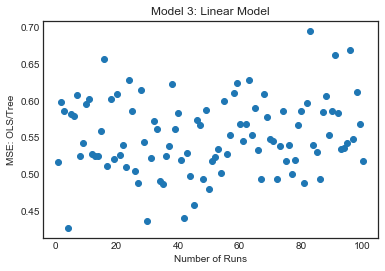

In [15]:
# Small MC experiments.
ratios = []
for _ in np.arange(100):
    ratios.append(sim_fun(n, k, beta_hat_3, tree3))

# Plot.
ax = plt.gca()
ax.plot(np.arange(100) + 1, ratios, 'o')
ax.set_xlabel('Number of Runs')
ax.set_ylabel('MSE: OLS/Tree')
ax.set_title('Model 3: Linear Model')

Plot all results in the same figure.

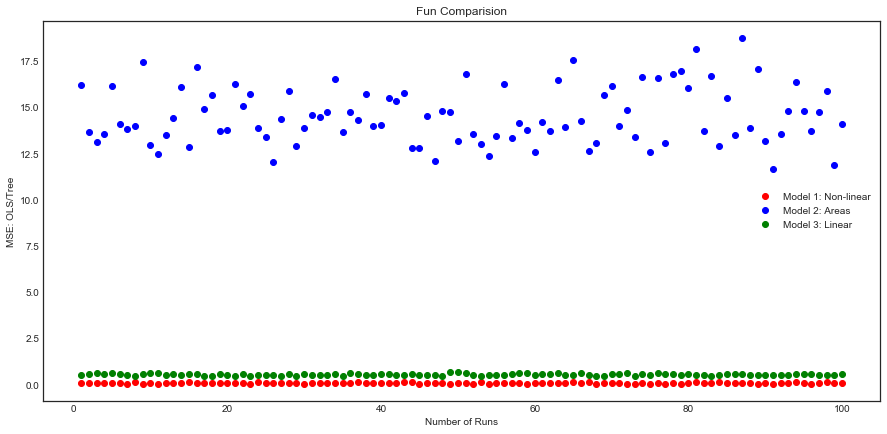

In [16]:
# Small MC experiments.
sim = 100
ratios_together = np.full((sim, 3), np.nan)

for i in np.arange(sim):
    ratios_together[i, 0] = sim_fun(n, 1, beta_hat_1, tree1)
    ratios_together[i, 1] = sim_fun(n, 2, beta_hat_2, tree2)
    ratios_together[i, 2] = sim_fun(n, 3, beta_hat_3, tree3)

# Plot.
xaxis = np.arange(sim) + 1

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(xaxis, ratios_together[:, 0], 'o', color='red', label='Model 1: Non-linear')
ax.plot(xaxis, ratios_together[:, 1], 'o', color='blue', label='Model 2: Areas')
ax.plot(xaxis, ratios_together[:, 2], 'o', color='green', label='Model 3: Linear')
ax.set_xlabel('Number of Runs')
ax.set_ylabel('MSE: OLS/Tree')
ax.set_title('Fun Comparision')
ax.legend()